## Modeling of a Convolutional Neural Network to detect Pneumonia in chest X-Rays

The following steps were conducted in the algorithm below <br>
1. Load libraries <br>
2. Amend database <br>
3. Split data in Training and Validation Set<br>
4. Augment image data <br>
5. Model configuration based on VGG16 <br>
6. Model Trainnig + Model Evaluation for different Architectures / Configurations <br>
7. Model extraction

### 1. Load libraries

In [1]:
# Below I just collate some libraries that were put to use during the course to make sure we don't forget anything.

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

import matplotlib.pyplot as plt

import sklearn
import sklearn.model_selection as skl
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve 
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix


import tensorflow as tf
import skimage
from skimage import io
import seaborn as snb

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from random import sample

from itertools import chain
import scipy
import scipy.stats

from scipy.ndimage import gaussian_filter

Using TensorFlow backend.


## 2. Amend Database

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
57925,00014346_024.png,Infiltration,24,14346,19,F,AP,3036,2544,0.139,0.139,NaN,/data/images_007/images/00014346_024.png
97698,00025787_021.png,Infiltration,21,25787,28,M,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00025787_021.png
39823,00010405_001.png,No Finding,1,10405,2,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010405_001.png


In [3]:
# In this step I create a binary classification for all Labels. If Existing = 1; Non-Existent = 0; Unique column per Findings Label

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
all_xray_df.sample(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12003,00003129_001.png,Infiltration,1,3129,61,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22267,00005907_002.png,No Finding,2,5907,35,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30959,00008051_042.png,No Finding,42,8051,49,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34269,00008998_000.png,No Finding,0,8998,57,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17750,00004801_001.png,Nodule,1,4801,91,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50571,00012829_005.png,Atelectasis,5,12829,53,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23287,00006167_000.png,Fibrosis,0,6167,50,F,PA,2500,2048,0.171,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95367,00025074_000.png,No Finding,0,25074,24,M,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
453,00000116_002.png,Effusion,2,116,75,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98801,00026124_000.png,No Finding,0,26124,46,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'] == 1, 'Pneumonia', 'No_Pneumonia')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
36847,00009703_003.png,Atelectasis,3,9703,66,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_Pneumonia
3890,00001071_000.png,No Finding,0,1071,64,F,PA,2986,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_Pneumonia
63371,00015646_043.png,No Finding,43,15646,66,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_Pneumonia


## 3. Create training and testing data:

In [5]:
# Let's first split the data generally whilst ensuring a real-life adequate distribution of Pneumonia 
# and then drill towards the right balance:

def create_splits(all_xray_df, test_size, target_column):
    
    train_data, val_data = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    
    return train_data, val_data


In [6]:
train_df, val_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')
print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)

train_df.shape: (89696, 29)
val_df.shape: (22424, 29)


In [7]:
all_xray_df['pneumonia_class'].value_counts(normalize=True) * 100

No_Pneumonia    98.723689
Pneumonia        1.276311
Name: pneumonia_class, dtype: float64

In [8]:
train_df['pneumonia_class'].value_counts(normalize=True) * 100

No_Pneumonia    98.723466
Pneumonia        1.276534
Name: pneumonia_class, dtype: float64

In [9]:
val_df['pneumonia_class'].value_counts(normalize=True) * 100

No_Pneumonia    98.724581
Pneumonia        1.275419
Name: pneumonia_class, dtype: float64

Very good, we can see that we achieved a very much harmonized distribution of Pneumonia cases between train_df and val_df.

Now we look to balance / 50-50 split the Training dataset for pps = Pneumonia patients and a sample of npps = non-pneumonia patients.

In [10]:
pps = train_df[train_df.pneumonia_class=='Pneumonia'].index.tolist()
npps =train_df[train_df.pneumonia_class=='No_Pneumonia'].index.tolist()

npp_sample=sample(npps, len(pps))
train_df=train_df.loc[pps+npp_sample]

In [11]:
#Test, if split resulted in 50-50 distribution of Pneumonia positive and negative in training set:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [12]:
train_df.shape

(2290, 29)

Good stuff, we have created a test-set that has 2290 images, whereof 50% or 1145 are Pneumonia labelled. <br>
<br>
Let's do the same for the validation set. Here we learned from project introduction, that in the clinical setting app 20% of all xRays are expected to show Pneumonia, wherefore our split should contain 80% Non-Pneumonia to 20% Pneumonia images for validation.

In [13]:
pps_2 = val_df[val_df.pneumonia_class=='Pneumonia'].index.tolist()
npps_2 = val_df[val_df.pneumonia_class=='No_Pneumonia'].index.tolist()

npp_sample_2 = sample(npps_2, 4*len(pps_2))
val_df = val_df.loc[pps_2 + npp_sample_2]

In [14]:
val_df['Pneumonia'].sum()/len(val_df)

0.2

In [15]:
val_df.shape

(1430, 29)

Brilliant, we achieved the same basic requirement for the validation set, where we created a set that has 1430 images, whereof 20% are Pneumonia labelled. <br>

To avoid critical error in the wild we should also review if we have created test and validation sets that reflect 'realistic' scenarios. In comparison to the full dataset we should also reflect our test and validation sets on <br>
- Age distribution <br>
- Distribution of Edema, Effusion, Infiltration and Atelectasis (key co-occuring diseases as mentioned during EDA) <br>
- Gender distribution <br>
- View position distribution

In [16]:
all_xray_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,00000462_000.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No_Pneumonia
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110689
mean,NaN,NaN,8.573751,14346.381743,46.901463,NaN,NaN,2646.078844,2486.438842,0.155649,...,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289,NaN
std,NaN,NaN,15.406320,8403.876972,16.839923,NaN,NaN,341.246429,401.268227,0.016174,...,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256,NaN
min,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,1143.000000,966.000000,0.115000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,0.000000,7310.750000,35.000000,NaN,NaN,2500.000000,2048.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [17]:
train_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
count,2290,2290,2290.000000,2290.000000,2290.000000,2290,2290,2290.000000,2290.000000,2290.000000,...,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290
unique,2290,221,NaN,NaN,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,00016646_002.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pneumonia
freq,1,647,NaN,NaN,NaN,1334,1220,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1145
mean,NaN,NaN,11.521834,14494.123144,45.891266,NaN,NaN,2656.051965,2464.853275,0.155391,...,0.007860,0.002183,0.294323,0.055459,0.282533,0.047162,0.030131,0.500000,0.041921,NaN
std,NaN,NaN,18.689075,8212.566738,18.850171,NaN,NaN,340.210776,396.937401,0.015881,...,0.088328,0.046686,0.455837,0.228923,0.450329,0.212031,0.170985,0.500109,0.200453,NaN
min,NaN,NaN,0.000000,13.000000,2.000000,NaN,NaN,1215.000000,1077.000000,0.115000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,1.000000,7735.000000,33.000000,NaN,NaN,2500.000000,2048.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,4.000000,14311.000000,48.000000,NaN,NaN,2500.000000,2532.500000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,NaN
75%,NaN,NaN,13.750000,20504.500000,58.000000,NaN,NaN,2992.000000,2991.000000,0.168000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,NaN


Test-Set review <br>
- Age distribution <br> Valid representation. Slightly younger patients in test set, but not critical. <br>
- Distribution of Edema, Effusion, Infiltration and Atelectasis (as mentioned during EDA key co-occuring diseases) <br> Valid representation. Higher share of these diseases in the test set, as can be expected due to co-occurence with Pneumonia. <br>
- Gender distribution <br> Valid representation. Slightly more male, as can be expected from higher share of Pneumonia labelled images (see EDA). <br>
- View position distribution <br> Valid representation. Higher share of AP than in general dataset as most Pneumonia-labelled images were more often taken from AP view (see EDA). <br>

In [18]:
val_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
count,1430,1430,1430.000000,1430.000000,1430.000000,1430,1430,1430.000000,1430.000000,1430.000000,...,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.00000,1430.000000,1430
unique,1430,153,NaN,NaN,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,00028509_024.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No_Pneumonia
freq,1,589,NaN,NaN,NaN,798,856,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1144
mean,NaN,NaN,9.684615,14374.437063,46.808392,NaN,NaN,2665.394406,2509.031469,0.154630,...,0.020979,0.002098,0.242657,0.039860,0.411888,0.052448,0.034965,0.20000,0.034266,NaN
std,NaN,NaN,17.017111,8397.873398,16.496739,NaN,NaN,338.038068,400.203936,0.015736,...,0.143364,0.045771,0.428840,0.195699,0.492347,0.223006,0.183756,0.40014,0.181975,NaN
min,NaN,NaN,0.000000,11.000000,3.000000,NaN,NaN,1537.000000,1572.000000,0.139000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,NaN,NaN,0.000000,7352.750000,34.000000,NaN,NaN,2500.000000,2048.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
50%,NaN,NaN,4.000000,14094.000000,49.000000,NaN,NaN,2560.000000,2544.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
75%,NaN,NaN,11.000000,20522.750000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,NaN


Validation-Set review <br>
- Age distribution <br> Valid representation. Slightly younger patients in validation set, but not critical. <br>
- Distribution of Edema, Effusion, Infiltration and Atelectasis (as mentioned during EDA key co-occuring diseases) <br> Valid representation. Higher share of these diseases in the validation set, as can be expected due to co-occurence with Pneumonia. <br>
- Gender distribution <br> Valid representation. Slightly more male (see EDA). <br>
- View position distribution <br> Valid representation. Higher share of AP than in general dataset as most Pneumonia-labelled images were more often taken from AP view (see EDA). <br>

# Now we can begin our model-building & training

### 4. Augment image data

Let's look at some of the pictures first, to be able to evaluate on what parameters we could set for augmentation.

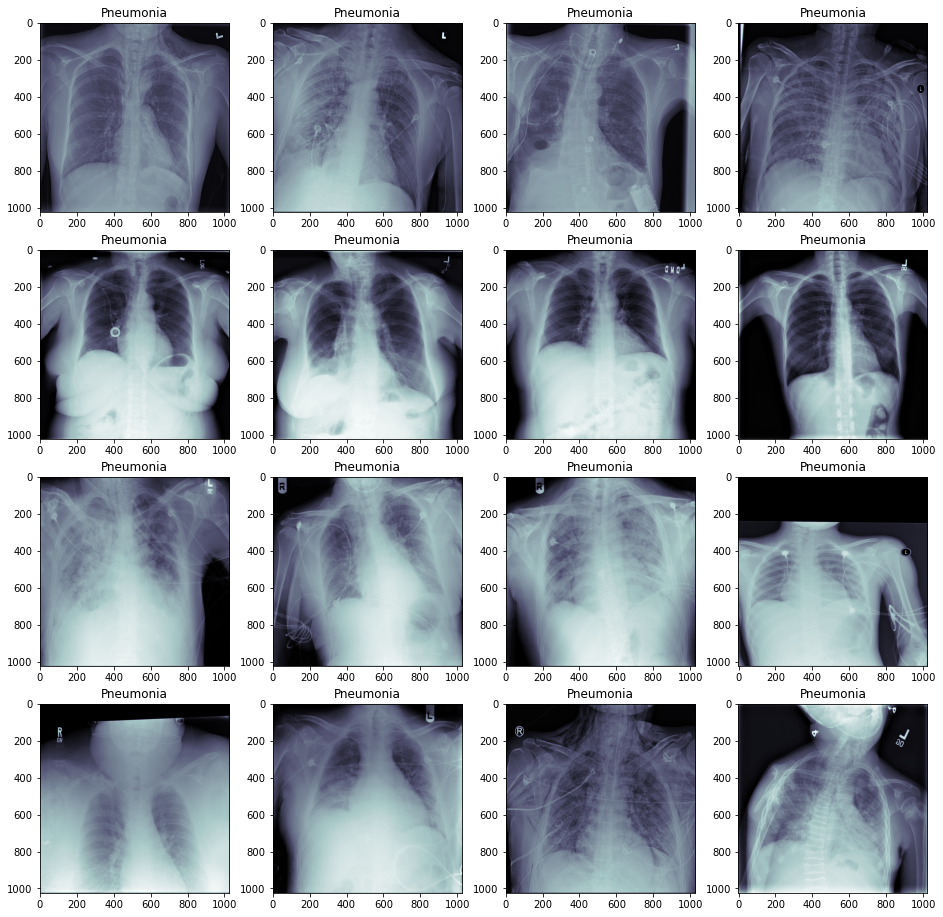

In [19]:
fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_df.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='bone')
    ax.set_title(train_df.iloc[ind]['pneumonia_class'])
    ind=ind+1

In [20]:
# In the following step we apply image augmentation, focused on the training data. 
# We'll also normalize the validation data to harmonize image data.

batch_size = 128
target_size = (224, 224)

def my_image_augmentation():
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.15)
    
    return my_idg


def make_train_gen(batch_size, target_size):
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = target_size, 
                                          batch_size = batch_size
                                          )

    return train_gen


def make_val_gen(batch_size, target_size):
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size
                                        )
    return val_gen 

In [21]:
train_gen = make_train_gen(batch_size, target_size)
val_gen = make_val_gen(batch_size, target_size)
#val_gen = make_val_gen(val_df, target_size)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [22]:
## Pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [23]:
len(valX)

128

In [24]:
len(valY)

128

_Note: For optimization of the following models different batch-sizes were tried, but sizes bigger than 128 (e.g. the full validation set's size) resulted in Error when trying to train the model due to Computational limitations.  Therefore Batch Size 128 was used for all following models._

Cool, we augmented the datasets to enhance training. <br>
Let's investigate on how much the images are changed via augmentation.

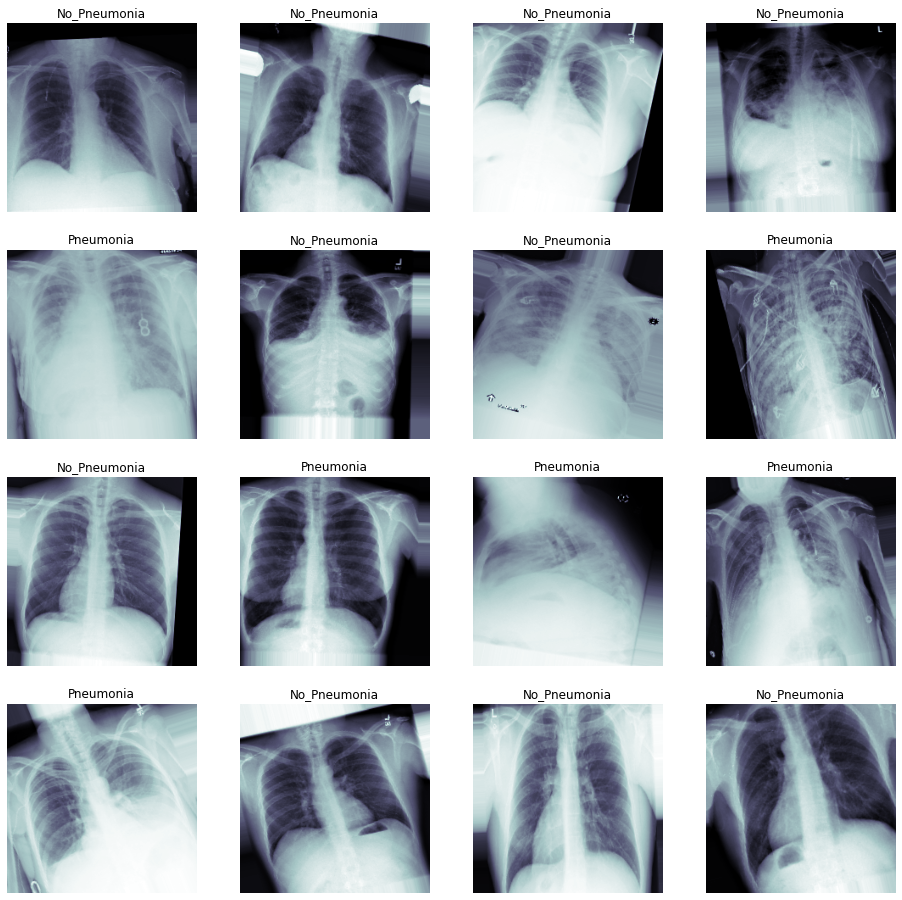

In [25]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No_Pneumonia')
    c_ax.axis('off')
    

It seems we chose some fair values for image augmentation. Images are different but still can be seen as realistic. <br> So let's move on.

## 5. Model configuration based on VGG16

In [26]:
# We first load VGG16 as the base model to build upon. 
# We apply a similar configuration to the one used during the Exercises.

def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

load_pretrained_model()

553467904/553467096 [==============================] - 10s 0us/step


In [27]:
vgg_model = load_pretrained_model()
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


# Model Architecture

In the next step we finally define the model parameters.
Also shared is a trial and error process considering different Architectures for the model and according performance statistics. 5 different configurations are shown below.

### ARCHITECTURE 1 - Dropout 0.4, Learning-Rate le-4

In [28]:

def build_Pneumonia_Checker_1_model():
    
    new_model = Sequential()
    
    new_model.add(vgg_model)
    
    new_model.add(Flatten())
    new_model.add(Dropout(0.4))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [29]:
Pneumonia_Checker_1 = build_Pneumonia_Checker_1_model()
Pneumonia_Checker_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [30]:
# In the next step we'll add some checkpoints as proposed to ensure we'll always be working with the best model.
# Key Metric of relevance is val_loss or improvement of predictability of outcome for the validation dataset. 
# Val_loss should be reduced with each epoch, otherwise the model might be overfitting to the training data. 
# Patience is set to 10, as this seems to be reasonable on running a maximum of 30 Epochs for training.

weight_path="{}_Pneumonia_Checker_1.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training Architecture 1! 

In [31]:
history = Pneumonia_Checker_1.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 30, 
                           callbacks = callbacks_list,
                            verbose = 1)


Epoch 1/30
18/18 [==============================] - 86s 5s/step - loss: 0.8200 - binary_accuracy: 0.4965 - val_loss: 0.6598 - val_binary_accuracy: 0.8000

Epoch 00001: val_loss improved from inf to 0.65977, saving model to xray_class_Pneumonia_Checker_1.best.hdf5
Epoch 2/30
18/18 [==============================] - 61s 3s/step - loss: 0.7334 - binary_accuracy: 0.5192 - val_loss: 0.6730 - val_binary_accuracy: 0.5678

Epoch 00002: val_loss did not improve from 0.65977
Epoch 3/30
18/18 [==============================] - 65s 4s/step - loss: 0.7075 - binary_accuracy: 0.5371 - val_loss: 0.6422 - val_binary_accuracy: 0.6993

Epoch 00003: val_loss improved from 0.65977 to 0.64216, saving model to xray_class_Pneumonia_Checker_1.best.hdf5
Epoch 4/30
18/18 [==============================] - 63s 3s/step - loss: 0.7079 - binary_accuracy: 0.5253 - val_loss: 0.6330 - val_binary_accuracy: 0.6469

Epoch 00004: val_loss improved from 0.64216 to 0.63300, saving model to xray_class_Pneumonia_Checker_1.best

In [32]:
## After training, we check some indicators to evaluate our model's overall performance

weight_path = 'xray_class_Pneumonia_Checker_1.best.hdf5'
Pneumonia_Checker_1.load_weights(weight_path)
predY_1 = Pneumonia_Checker_1.predict(valX, batch_size = 128, verbose = True)

128/128 [==============================] - 1s 11ms/step


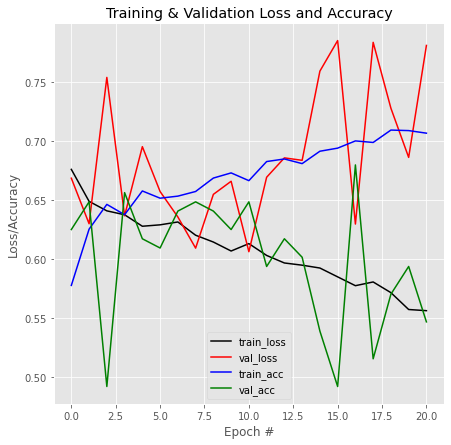

In [77]:
# Model Training history:

def plot_history(history):        
    # Todo
    x_values = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    plt.figure(figsize=(7,7))
    for ind, metric in enumerate(metrics):
        plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    plt.title("Training & Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")    
    return
    
hist = plot_history(history)

_Note: The history plot does not reflect the history of training of Pneumonia Checker 1, as I unintentionally overwrote it when trying to add the Accuracy information. And as I'm new to Python I'm not aware of how to recapture the information in a diagram. From the following Architectures history plots you can see that I'm capable of reading and interpreting those. For the FDA exercise hand-in I created a similar diagram in Excel capitalizing on the training progress data as shown above._

In [34]:
def plot_auc(t_y, p_y):
    
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return

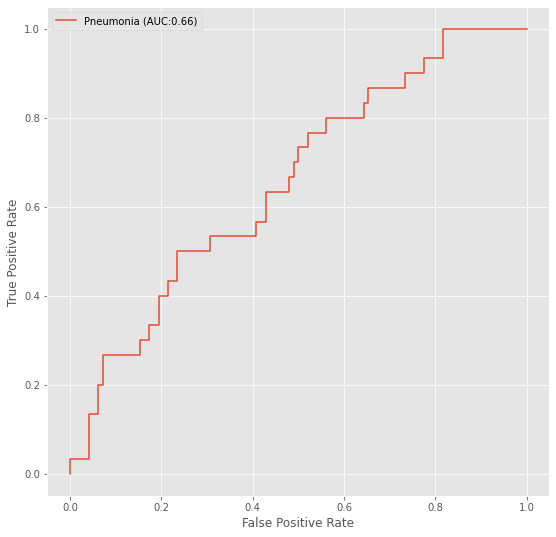

In [35]:
plot_auc(valY, predY_1)

In [36]:
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

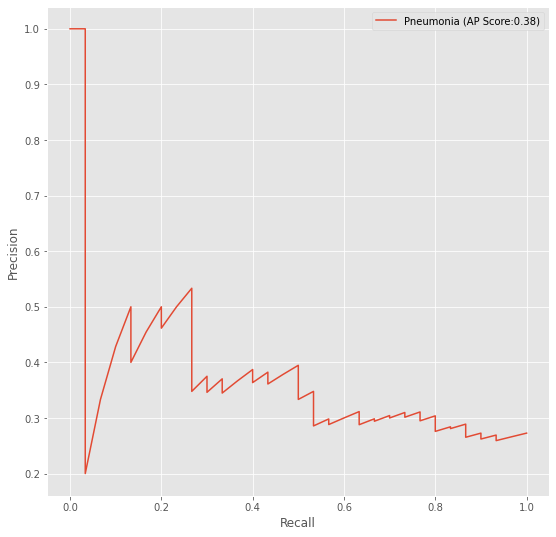

In [37]:
plot_precision_recall_curve(valY, predY_1)

In [38]:
# function to calculate the F1 score
def calc_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)

# function to obtain threshold at maximum f1_score => best threshold

def best_threshold(precision, recall):
       
    f1_score = calc_f1(precision, recall)
    idx_max_f1_score = np.nanargmax(f1_score) # find the index at maximum f1_score
    best_threshold = thresholds[idx_max_f1_score]
    # print corresponding threshold, precision and recall
    print('Threshold that maximized f1_score is: %.3f'%best_threshold)
    print('Corresponding Precision is: %.3f'%precision[idx_max_f1_score])
    print('Recall is: %.2f'%recall[idx_max_f1_score])
    
    return best_threshold

In [39]:
def f1_plot(t_y, p_y):
        
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thresholds]
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(thresholds, f1s, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1_score vs Threshold')

    return

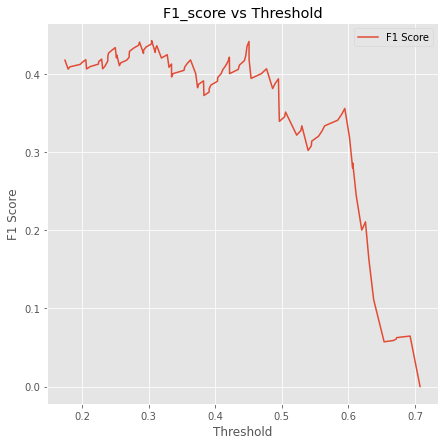

In [40]:
f1_plot(valY, predY_1)

In [41]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(valY, predY_1)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.3108108108108108
Recall: 0.7666666666666667
Threshold: 0.30987814
F1 Score: 0.4423076923076923


Comparing F1-Scores between our model Pneumonia_Checker_1 at 0.442 as shown above we can see it performs better than the average radiologist at 0.387 (see literature). At this value the Recall is at 0.767, which should allow us to be confident that many False Negative results are avoided in our model. As we can see from the learning history we also see a "path towards a decent model" / the bottom right, which is showing a positive training over time. Let's try to improve that result. <br>

In the next step we'll investigate if we can improve performance by adding another layer to the CNN.

### ARCHITECTURE 2 - Dropout at 0.4, Learning-Rate le-4, add. 128 Layer

In [42]:
def build_Pneumonia_Checker_2_model():
    
    new_model = Sequential()
    
    new_model.add(vgg_model)
    
    new_model.add(Flatten())
    new_model.add(Dropout(0.4))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [43]:
Pneumonia_Checker_2 = build_Pneumonia_Checker_2_model()
Pneumonia_Checker_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [44]:
weight_path="{}_Pneumonia_Checker_2.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training Architecture 2!

In [45]:
history = Pneumonia_Checker_2.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 30, 
                           callbacks = callbacks_list)


Epoch 1/30
18/18 [==============================] - 62s 3s/step - loss: 0.7000 - binary_accuracy: 0.5301 - val_loss: 0.6434 - val_binary_accuracy: 0.7422

Epoch 00001: val_loss improved from inf to 0.64340, saving model to xray_class_Pneumonia_Checker_2.best.hdf5
Epoch 2/30
18/18 [==============================] - 60s 3s/step - loss: 0.6908 - binary_accuracy: 0.5393 - val_loss: 0.6552 - val_binary_accuracy: 0.6484

Epoch 00002: val_loss did not improve from 0.64340
Epoch 3/30
18/18 [==============================] - 60s 3s/step - loss: 0.6774 - binary_accuracy: 0.5760 - val_loss: 0.6427 - val_binary_accuracy: 0.6250

Epoch 00003: val_loss improved from 0.64340 to 0.64275, saving model to xray_class_Pneumonia_Checker_2.best.hdf5
Epoch 4/30
18/18 [==============================] - 60s 3s/step - loss: 0.6712 - binary_accuracy: 0.5913 - val_loss: 0.6097 - val_binary_accuracy: 0.6641

Epoch 00004: val_loss improved from 0.64275 to 0.60973, saving model to xray_class_Pneumonia_Checker_2.best

In [46]:
weight_path = 'xray_class_Pneumonia_Checker_2.best.hdf5'
Pneumonia_Checker_2.load_weights(weight_path)
predY_2 = Pneumonia_Checker_2.predict(valX, batch_size = 128, verbose = True)

128/128 [==============================] - 1s 10ms/step


In [ ]:
# Model Training history:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

plot_history(history)

In [48]:
def plot_auc(t_y, p_y):
    
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return

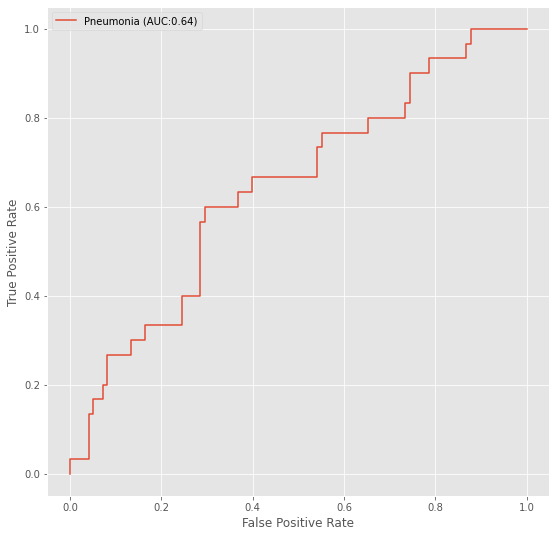

In [49]:
plot_auc(valY, predY_2)

In [50]:
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

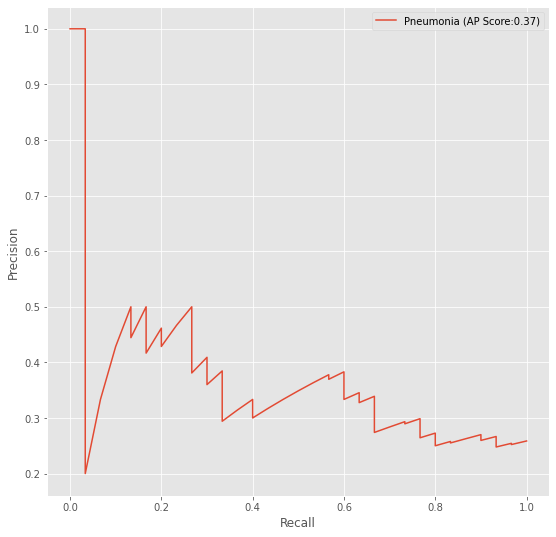

In [51]:
plot_precision_recall_curve(valY, predY_2)

In [52]:
# function to calculate the F1 score
def calc_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)

# function to obtain threshold at maximum f1_score => best threshold

def best_threshold(precision, recall):
       
    f1_score = calc_f1(precision, recall)
    idx_max_f1_score = np.nanargmax(f1_score) # find the index at maximum f1_score
    best_threshold = thresholds[idx_max_f1_score]
    # print corresponding threshold, precision and recall
    print('Threshold that maximized f1_score is: %.3f'%best_threshold)
    print('Corresponding Precision is: %.3f'%precision[idx_max_f1_score])
    print('Recall is: %.2f'%recall[idx_max_f1_score])
    
    return best_threshold

In [53]:
def f1_plot(t_y, p_y):
        
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thresholds]
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(thresholds, f1s, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1_score vs Threshold')

    return

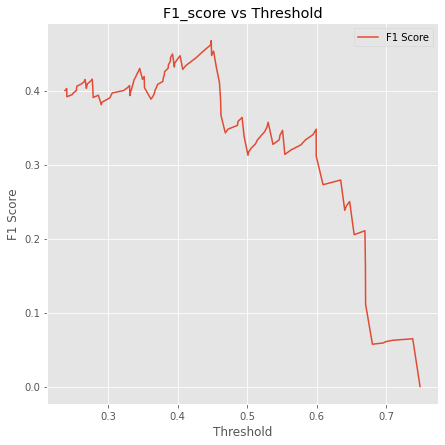

In [54]:
f1_plot(valY, predY_2)

In [55]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(valY, predY_2)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.3829787234042553
Recall: 0.6
Threshold: 0.44896522
F1 Score: 0.4675324675324675


Comparing F1-Scores between our model Pneumonia_Checker_2 at 0.468 as shown above we can see it performs better than the average radiologist at 0.387 (see literature), and also better than PC1. But the Learning History curve shows us that while the fit to the training data was improved with each Epoch, the predictability of validation data was not significantly improved. The result might be achieved a little random.

This might also be a potentially helpful model, but at this stage I'd prefer to keep PC1 as preferred model. Let's try adjusting the Dropout scenario and reflect, if we can improve PC1 from there.

### ARCHITECTURE 3 - Dropout 0.2, Learning-Rate le-4, no add. 128 Layer

In [56]:
def build_Pneumonia_Checker_3_model():
    
    new_model = Sequential()
    
    new_model.add(vgg_model)
    
    new_model.add(Flatten())
    new_model.add(Dropout(0.2))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [57]:
Pneumonia_Checker_3 = build_Pneumonia_Checker_3_model()
Pneumonia_Checker_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)              

In [58]:
weight_path="{}_Pneumonia_Checker_3.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training Architecture 3! 

In [59]:
history = Pneumonia_Checker_3.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 30, 
                           callbacks = callbacks_list)


Epoch 1/30
18/18 [==============================] - 63s 3s/step - loss: 0.6760 - binary_accuracy: 0.5777 - val_loss: 0.6684 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.66844, saving model to xray_class_Pneumonia_Checker_3.best.hdf5
Epoch 2/30
18/18 [==============================] - 60s 3s/step - loss: 0.6488 - binary_accuracy: 0.6253 - val_loss: 0.6299 - val_binary_accuracy: 0.6484

Epoch 00002: val_loss improved from 0.66844 to 0.62990, saving model to xray_class_Pneumonia_Checker_3.best.hdf5
Epoch 3/30
18/18 [==============================] - 60s 3s/step - loss: 0.6410 - binary_accuracy: 0.6463 - val_loss: 0.7537 - val_binary_accuracy: 0.4922

Epoch 00003: val_loss did not improve from 0.62990
Epoch 4/30
18/18 [==============================] - 60s 3s/step - loss: 0.6374 - binary_accuracy: 0.6376 - val_loss: 0.6367 - val_binary_accuracy: 0.6562

Epoch 00004: val_loss did not improve from 0.62990
Epoch 5/30
18/18 [==============================] - 60s 

In [60]:
weight_path = 'xray_class_Pneumonia_Checker_3.best.hdf5'
Pneumonia_Checker_3.load_weights(weight_path)
predY_3 = Pneumonia_Checker_3.predict(valX, batch_size = 128, verbose = True)

128/128 [==============================] - 1s 10ms/step


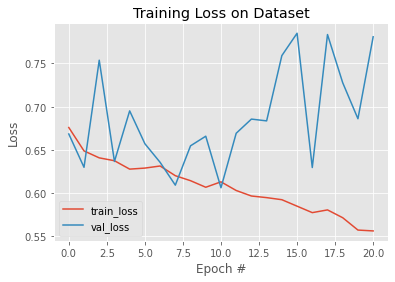

In [61]:
# Model Training history:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

plot_history(history)

In [62]:
def plot_auc(t_y, p_y):
    
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return

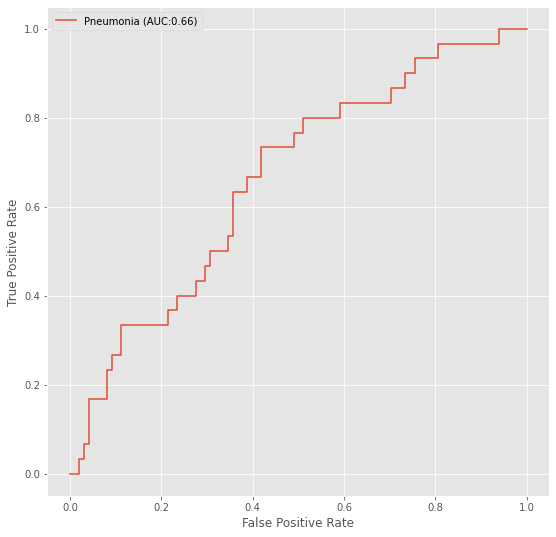

In [63]:
plot_auc(valY, predY_3)

In [64]:
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

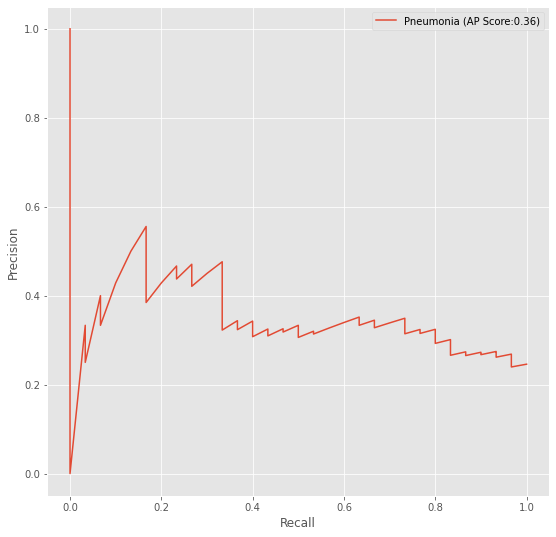

In [65]:
plot_precision_recall_curve(valY, predY_3)

In [66]:
# function to calculate the F1 score
def calc_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)

# function to obtain threshold at maximum f1_score => best threshold

def best_threshold(precision, recall):
       
    f1_score = calc_f1(precision, recall)
    idx_max_f1_score = np.nanargmax(f1_score) # find the index at maximum f1_score
    best_threshold = thresholds[idx_max_f1_score]
    # print corresponding threshold, precision and recall
    print('Threshold that maximized f1_score is: %.3f'%best_threshold)
    print('Corresponding Precision is: %.3f'%precision[idx_max_f1_score])
    print('Recall is: %.2f'%recall[idx_max_f1_score])
    
    return best_threshold

In [67]:
def f1_plot(t_y, p_y):
        
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thresholds]
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(thresholds, f1s, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1_score vs Threshold')

    return

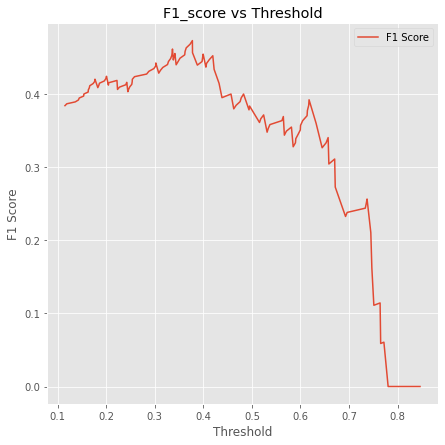

In [68]:
f1_plot(valY, predY_3)

In [69]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(valY, predY_3)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.3492063492063492
Recall: 0.7333333333333333
Threshold: 0.37779477
F1 Score: 0.4731182795698924


Comparing F1-Scores between our model Pneumonia_Checker_3 at 0.473 as shown above we can see it performs better than the average radiologist at 0.387 (see literature) and also better than PC1. <br>
But.. the result seems to be achieved rather random - we cannot see the expected "continuous improvement" of the learning curve towards optimized val_loss. Therefore we might have overfitted to the training data and did not achieve a really good model, able to perform well in a real-life scenario.

_Note: Many more options for model configuration were tried (e.g. Batch sizes, layers, Learning rates, Dropout configurations), but of course not all results are represented here. Results shown above are a snaphot of the process._

From evaluating the Performance criteria Model Pneumonia_Checker_1 was chosen for further investigation. It has a promising F1 score, good recall, and does not seem to be heavily overfitted to training data.

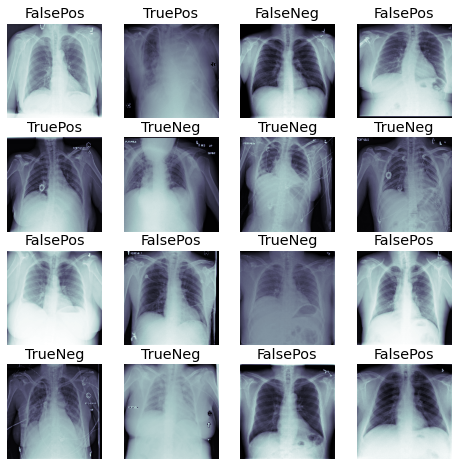

In [74]:
## Let's look at some examples of true vs. predicted with our best model, Pneumonia_Checker_1: 

YOUR_THRESHOLD = 0.31

fig, m_axs = plt.subplots(4, 4, figsize = (8, 8))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:128], valY[0:128], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if predY_1[i] > YOUR_THRESHOLD:
            c_ax.set_title('TruePos')
        else:
            c_ax.set_title('FalseNeg')
    else:
        if predY_1[i] < YOUR_THRESHOLD:
            c_ax.set_title('FalsePos')
        else:
            c_ax.set_title('TrueNeg')
    c_ax.axis('off')
    i=i+1

In [75]:
## Finally we save our model architecture to a .json:

model_json = Pneumonia_Checker_1.to_json()
with open("Pneumonia_Checker_1.json", "w") as json_file:
    json_file.write(model_json)